# Carlos Adrián García Estrada
# Matricula: A01707503
# Fecha de entrega: 19 de noviembre de 2023

# Solución: 
 
Para mi solución implente que durante el movimiento de los agentes se priorizar el seteo de aquellas celdas que serían stacks.
Se calculo el numero de stacks necesarios a través de la divisón de la cantidad de cajas entre la capacidad máxima de los stacks
resultando en 200 stacks.

Tambien se calcula en todo momento las celdas adyacentes al agente en las 4 direcciónes a través de la resta y suma correspondiente en
los ejes x y y.

Una vez hecho el calculo la primera acción del agente es encontrar celdas tanto vacías ( ni ocuapdas por otros agentes o por cajas)
como con cajas a su alrededor, si encuentra una caja del tamaño que sea la seteara como stack y esto se repetira por todos los agentes
hasta haber seteado los 40 stacks. Una vez hecho eso ahora el agente buscara si esta cargando o no una caja y si la celda con caja que 
eligio haya sido seteada como stack, si si ha sido seteada y esta cargando una caja dejará la caja. si no ha sido seteado como stack y 
no tiene una caja cargando entonces tomará una de las cajas.. SI ninguno de los casos se cumplen el agente se moverá a una celda vacía. 
De esto modo solo podemos tomar cajas de celdas que no han sido definidas como stack y solo ponerlas en aquellas que sí. Una vez que se 
hayan completado las 40 stacks de 5 cajas la simulación parará. Para el calculo de stacks completos cada vez que se coloca una nueva caja
se revisa si esta ha llegado a una cantidad de 5 stacks si llego entonces se le suma 1 a la cantidad de stacks completos y se le resta 1 a
stacks incompletos.

# Como eficientar el algoritmo 
Aunque los pasos son mas de 7000 la computacion de ellos es de hecho bastante rapida a comparación de la iteración de mi propuesta de solucion
para el cleaning Model. En este modelo los 7245 pasos tardan menos de 10 segundos en ser procesados mientras que en el cleanin model 10000 pasos tardaban más de 10 minutos. Para hacer aún más eficiente el algoritmo
se podría hacer array de las posiciónes de los stacks seteados y que puedan ser accedido por los agentes en cualquier momento, además de
crear un método que lleve al agente a la celda deseada step por step en vez de esperar a que por chance se encuentre.

In [2]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

from mesa.space import MultiGrid

#Importamos Random Activation ya que queremos que los agentes tomen decisiones 1 a la vez para evitar conflictos de choque
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

#Importamos random para obtener coordenadas al azar para setear nuestros dirty cells
import random

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [3]:
class OrderingAgent(Agent):
    def __init__(self, unique_id, model):
        random.seed(67890)  #Establecemos misma semilla random para evitar variaciones
        super().__init__(unique_id, model)
        self.carrying_boxes = 0 

    def get_adjacent_cells(self): #Con este método obtenemos solo las celdas de arriba abajo, dercecha e izquierda al restar y sumar a la coordenada específica
        x, y = self.pos
        grid_width = self.model.grid.width
        grid_height = self.model.grid.height

        adjacent_cells = []

        left_x = x - 1
        if left_x >= 0:
            adjacent_cells.append((left_x, y))

        right_x = x + 1
        if right_x < grid_width:
            adjacent_cells.append((right_x, y))

        up_y = y - 1
        if up_y >= 0:
            adjacent_cells.append((x, up_y))

        down_y = y + 1
        if down_y < grid_height:
            adjacent_cells.append((x, down_y))

        return adjacent_cells
    
    def step(self):
        

        adjacent_cells = self.get_adjacent_cells()
        #Filtramos las celdas vacías solo desde las adjacentes al comprobar si hay una agente o si hay una caja
        empty_cells = [cell for cell in adjacent_cells if (self.model.grid.is_cell_empty(cell) and 
                                                           self.model.get_type(cell[0], cell[1]) == 0)] 
        
        #Filtramos las celdas unicamente con el tipo cajas de 1 a 4 puesto que una con 5 cajas sería un stack completo
        box_cells = [cell for cell in adjacent_cells if (0 < self.model.get_type(cell[0], cell[1]) < 5)] 

        if empty_cells:
            
            if box_cells:

                #Elegimos una caja al azar y procedemos a comprobar
                chosen_box_cell = self.random.choice(box_cells)
                
                #Todos los agentes tienen como prioridad el establecer las 40 celdas con stacks que guardaran todas las cajas
                if self.model.get_total_stacks() < 40:

                    #Solamente si la caja no ha sido marcada como stack previamente y si hay menos de 40 stacks se establecerá un nuevo stack
                    if self.model.get_stack(chosen_box_cell[0], chosen_box_cell[1]) == 0:
                            
                            self.model.set_stack(chosen_box_cell[0], chosen_box_cell[1])
                    else:
                        empty_cell = self.random.choice(empty_cells)
                        self.model.grid.move_agent(self, empty_cell)

                else:
                    #El agente comprueba que la caja elegida no sea stack y que no tenga ya cargando una caja, solo de esa manera puede
                    #puede recoger la caja de la celda
                    if self.model.get_stack(chosen_box_cell[0], chosen_box_cell[1]) == 0 and self.carrying_boxes == 0:
                        self.carrying_boxes += 1
                        self.model.take_box(chosen_box_cell[0], chosen_box_cell[1])
                        empty_cell = self.random.choice(empty_cells)
                        self.model.grid.move_agent(self, empty_cell)

                    #El agente comprueba que la caja elegida sea stack y que tenga cargando unna caja, solo de esa manera puede
                    #puede poner la caja en la celda

                    if self.model.get_stack(chosen_box_cell[0], chosen_box_cell[1]) == 1 and self.carrying_boxes == 1: 
                        if self.carrying_boxes == 1:
                            self.carrying_boxes -= 1
                            self.model.place_box(chosen_box_cell[0], chosen_box_cell[1])
                            empty_cell = self.random.choice(empty_cells)
                            self.model.grid.move_agent(self, empty_cell)

                    #Si ninguno de estas condiciones el agente se movera a una celda vacía
                    else:
                        empty_cell = self.random.choice(empty_cells)
                        self.model.grid.move_agent(self, empty_cell)
            else:
                empty_cell = self.random.choice(empty_cells)
                self.model.grid.move_agent(self, empty_cell)

   

In [4]:
#En get_grid obtenemos los contenidos de nuestra celda y seteamos valores numéricos
#para después setear los colores en el grid

def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height), dtype=int)
    
    for (content, (x, y)) in model.grid.coord_iter():
        if content:
            grid[x][y] = 1  # Representamos al agente con el numero 1 en el grid
         
        elif model.get_type(x, y) == 1: #Hacemos lo mismo con la cantidad de cajas solo que agregamos +1 ya que el agente ya ocupa un número
            grid[x][y] = 2 

        elif model.get_type(x, y) == 2: 
            grid[x][y] = 3  

        elif model.get_type(x, y) == 3: 
            grid[x][y] = 4  

        elif model.get_type(x, y) == 4: 
            grid[x][y] = 5  
        
        elif model.get_type(x, y) == 5: 
            grid[x][y] = 6  

        else:
            grid[x][y] = 0  #De otro modo se seteara cero para las celdas vacías
    return grid

In [5]:
class OrderingModel(Model):
    def __init__(self, width, height, box_quantity, num_agents):
        #Seteamos variables importante nuevas como lo es stacks incompletos y completos, saber si una celda es stack y la cantida de
        #cajas en una celda con type
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        self.type = np.zeros((width, height))
        self.complete_stacks = 0
        self.incomplete_stacks = 0
        self.is_stack = np.zeros((width, height))
        self.running = True
        id = 1

        #Seteamos el random seed
        random.seed(67890)

        #Iniciamos variables en cero
        for x in range(width):
            for y in range(height):
                self.type[x][y] = 0
                self.is_stack[x][y] = 0

        #Seteamos las cajas en coordenadas random, comprobamos el valor de cajas faltantes para modificar el limite de "choice" para evitar
        #sobrepasar el limite de 200 cajas

        for i in range(box_quantity):
            x, y = random.randrange(self.grid.width), random.randrange(self.grid.height)

            while not (self.grid.is_cell_empty((x, y)) and self.get_type(x, y) == 0):
                x, y = random.randrange(self.grid.width), random.randrange(self.grid.height)

            if box_quantity >= 3:
                choice = self.random.randint(1, 3)
            
            elif box_quantity == 2:
                choice = self.random.randint(1, 2)

            elif box_quantity == 1:
                choice = 1
            box_quantity = max(0, box_quantity - choice)
            self.type[x][y] = choice

            if box_quantity <= 0:
                break

        #Seteamos los agentes en posiciones randomizadas
        for i in range(num_agents):
            x, y = random.randrange(self.grid.width), random.randrange(self.grid.height)

            while not (self.grid.is_cell_empty((x, y)) and self.get_type(x, y) == 0):
                x, y = random.randrange(self.grid.width), random.randrange(self.grid.height)

            ordering_agent = OrderingAgent(id, self)
            self.grid.place_agent(ordering_agent, (x, y))
            self.schedule.add(ordering_agent)
            id = id + 1
        
    # Si el agente toma una caja con las condiciones previamente establecidas se le resta -1 a el tipo en esa celda y se le agrega al agente 
    #en carrying boxes 
    def take_box(self, x, y):
        self.type[x][y] -= 1

    #Si el agente coloca una caja entonces se le sumara +1 al tipo de la celda, comprobamos si el tipo es 5, si lo es significa que el stack
    #esta completo

    def place_box(self, x, y):   
        self.type[x][y] += 1
        if self.type[x][y] == 5:
            self.complete_stacks += 1
            self.incomplete_stacks -= 1

    def get_type(self, x, y):
        return self.type[x][y]

    #Cada que seteamos stack aumentamos la cantidad de stacks incompleto
    def set_stack(self, x, y):
        if self.is_stack[x][y] == 0:
            self.is_stack[x][y] = 1
            self.incomplete_stacks += 1

    def get_stack(self, x, y):
        return self.is_stack[x][y]

    #De esta manera comprobamos que no nos pasemos de limite de 40 stacks
    def get_total_stacks(self):
        return self.incomplete_stacks + self.complete_stacks

    def step(self):

        self.datacollector.collect(self)
        self.schedule.step()
        #La simulacion termina una vez que esten hechos 40 stacks completos
        if self.complete_stacks == 40:
            print("Simulación completa")
            self.running = False

              

In [6]:
WIDTH = 20
HEIGHT = 20
BOX_QUANTITY = 200  
NUM_AGENTS = 5

#comenzamos con el caluclo del tiempo
start_time = time.time()

model = OrderingModel(WIDTH, HEIGHT, BOX_QUANTITY, NUM_AGENTS)

step_counter = 0

#llamamos al modelo y contamos los steps hasta que acabe
while model.running:
    model.step()
    step_counter += 1
    
print('Numero de pasos:', step_counter)
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))

Simulación completa
Numero de pasos: 13114
Tiempo de ejecución: 0:00:13.867206


In [7]:
#Recolectamos los datos del grid 
all_grid = model.datacollector.get_model_vars_dataframe()

C:\Users\Charlie\AppData\Local\Temp\ipykernel_26596\697283093.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(all_grid.iloc[0][0], cmap=cmap, vmin=0, vmax=6)
C:\Users\Charlie\AppData\Local\Temp\ipykernel_26596\697283093.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grid.iloc[i][0])


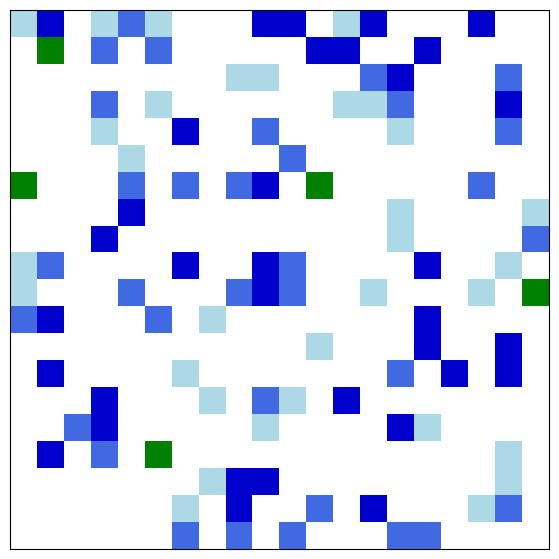

In [8]:

fig, axs = plt.subplots(figsize=(7, 7))
axs.set_xticks([])
axs.set_yticks([])

# Definimos los colores para la animación
cmap = plt.cm.colors.ListedColormap(['white', 'green', 'lightblue', 'royalblue', 'mediumblue', 'darkblue', 'black'])

#Seteamos los valores estbalecidos en el grid
bounds = [0, 1, 2, 3, 4, 5, 6]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

patch = plt.imshow(all_grid.iloc[0][0], cmap=cmap, vmin=0, vmax=6)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    patch.set_clim(vmin=0, vmax=6)  #establecemos los limites del color

anim = animation.FuncAnimation(fig, animate, frames=step_counter)


In [9]:
anim

C:\Users\Charlie\AppData\Local\Temp\ipykernel_26596\697283093.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grid.iloc[i][0])
